In [10]:
from datetime import datetime as dt

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import GradientBoostingRegressor as gbr

from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

import xgboost as xgb

url='https://drive.google.com/file/d/1-4YpXkd2kIOM5viSRw8g7oOQm8sicciB/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
y_train = pd.read_csv(url, index_col=0)

url='https://drive.google.com/file/d/1-7VK3dNry2-AYnfRsxMWsOKhHHMTN_ZA/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
test_indices = pd.read_csv(url, index_col=0)

In [11]:
def month_to_season(month: int):
    if month < 4:
        return "winter"
    elif month < 7:
        return "spring"
    elif month < 10:
        return "summer"
    elif month < 13:
        return "fall"

In [12]:
df = pd.read_csv("weather.csv")

In [13]:
df["timestamp"] = df[["timestamp"]].apply(lambda x: f"{x[0][0:4]}-{x[0][4:6]}-{x[0][6:8]}", axis=1)

In [14]:
# df[["timestamp"]].apply(lambda x: f"{x[0][0:4]}-{x[0][4:6]}-{x[0][6:8]}", axis=1)
df = df.groupby("timestamp").mean()
df = df[df.index >= "2009-12-28"]

In [15]:
fitted_df = pd.DataFrame(df.iloc[0:7].sum() / 7, columns=[f"{df.index[0]}/{df.index[6]}"]).transpose()
for i in range(7, len(df.index), 7):
    fitted_df = pd.concat([fitted_df, pd.DataFrame(df.iloc[i:i + 7].sum() / 7, columns=[f"{df.index[i]}/{df.index[i + 6]}"]).transpose()])

In [16]:
fitted_df.index.name="year_weeks"

In [17]:
y_train = pd.concat([y_train, fitted_df.iloc[0:len(y_train.index)]], axis=1)
y_train.index.name = "year_weeks"

In [80]:
train = y_train.reset_index()
melted_train = pd.melt(train, id_vars=["year_weeks", "Temperature", "Relative Humidity", "Wind Speed", "Wind Direction"], var_name="City", value_name="Weight")
melted_train["temp"] = melted_train[["City"]].apply(lambda x: x[0].split("_"), axis=1)
melted_train[["food", "district"]] = pd.DataFrame(melted_train["temp"].tolist())

melted_train["month"] = list(map(lambda x: int(x.split("/")[1].split("-")[1]), melted_train.year_weeks))
melted_train["day"] = list(map(lambda x: int(x.split("/")[1].split("-")[2]), melted_train.year_weeks))
melted_train["season"] = list(map(lambda x: month_to_season(x), melted_train.month))

melted_train = melted_train[["year_weeks", "month", "day", "season", "year_weeks", "Temperature",
                             "Relative Humidity", "Wind Speed", "Wind Direction", "food", "district", "Weight"]]
X_train_df = pd.concat([pd.get_dummies(melted_train["month"]),
                        # pd.get_dummies(melted_train["day"]),
                        # pd.get_dummies(melted_train["season"]),
                        # melted_train["Temperature"],
                        # melted_train["Relative Humidity"],
                        # melted_train["Wind Speed"],
                        # melted_train["Wind Direction"],
                        pd.get_dummies(melted_train["food"]),
                        pd.get_dummies(melted_train["district"])], axis=1)
X_train = X_train_df.to_numpy()
Y_train = melted_train["Weight"].to_numpy()


In [81]:
ddd = pd.DataFrame(y_train.sum(), columns=["sum"])
zeros = ddd[ddd["sum"] == 0].index.tolist()
zeros

['לפת_מחוז חיפה',
 'ענבים_מחוז תל אביב',
 'פלפלים_מחוז תל אביב',
 'צנון_מחוז ירושלים',
 'קישואים_יהודה ושומרון',
 'תפו"א_יהודה ושומרון',
 'תפו"א_מחוז ירושלים']

In [83]:
# model = rfr(max_depth=14, n_estimators=120, max_features=47, random_state=3, bootstrap=True)
# model = gbr(max_features=47, n_estimators=120, max_depth=14, random_state=0)
model = dtr(max_depth=15, min_samples_split=105, max_features=46, random_state=0)
model.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=15, max_features=46, min_samples_split=105,
                      random_state=0)

In [84]:
Y_pred = model.predict(X_train)
Y_pred = np.array(map(lambda x: x if x >= 0 else 0, Y_pred))
melted_train["pred"] = Y_pred
for e in zeros:
    food, location = e.split("_")
    melted_train.loc[(melted_train["food"] == food) & (melted_train["district"] == location), ["pred"]] = 0
Y_pred = melted_train["pred"].to_numpy()

In [274]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
X_train_08, X_test_02, Y_train_08, Y_test_02 = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)


param = {'max_depth': 16, 'eta': 1, 'objective': 'reg:tweedie'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

dtrain = xgb.DMatrix(X_train_08, label=Y_train_08)

num_rounds = 30
bst = xgb.train(param, dtrain, num_rounds)
# print(X_train_08)

In [275]:
dtest = xgb.DMatrix(X_train)
bst.predict(dtest)

array([3.7205879e+01, 3.7205879e+01, 3.7205879e+01, ..., 2.1905837e-06,
       3.6039996e-06, 3.6039996e-06], dtype=float32)

In [85]:
mean_squared_error(Y_train, Y_pred, squared=False)

5997.809362508124

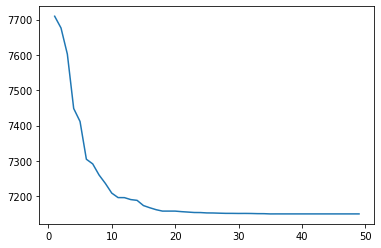

In [110]:
# decision tree cv


RMSE = []
E = 50
for i in range(1, E):
    print(i, end="\r")
    model = dtr(max_depth=i, random_state=0)
    model.fit(X_train_08, Y_train_08)
    RMSE.append(mean_squared_error(Y_test_02, model.predict(X_test_02), squared=False))
plt.plot(np.arange(1, E), RMSE)


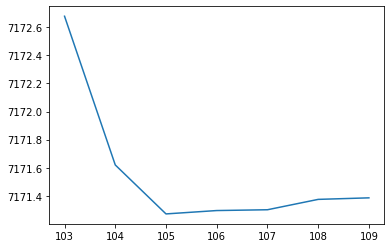

In [123]:
RMSE = []
S = 103
E = 110
loop_range = np.arange(S, E, 1)

for i in loop_range:
    print(i, end="\r")
    model = dtr(max_depth=15, min_samples_split=i, random_state=0)
    model.fit(X_train_08, Y_train_08)
    RMSE.append(mean_squared_error(Y_test_02, model.predict(X_test_02), squared=False))
plt.plot(loop_range, RMSE)


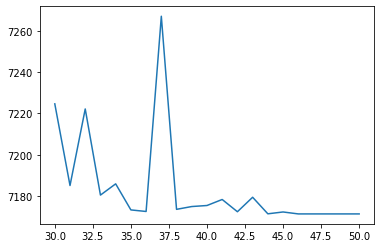

In [148]:
RMSE = []
S = 30
E = 51
loop_range = np.arange(S, E, 1)

for i in loop_range:
    print(i, end="\r")
    model = dtr(max_depth=15, min_samples_split=105, max_features=i, random_state=0)
    model.fit(X_train_08, Y_train_08)
    RMSE.append(mean_squared_error(Y_test_02, model.predict(X_test_02), squared=False))
plt.plot(loop_range, RMSE)


In [149]:
RMSE = np.array(RMSE)
loop_range[RMSE.argmin()]

46

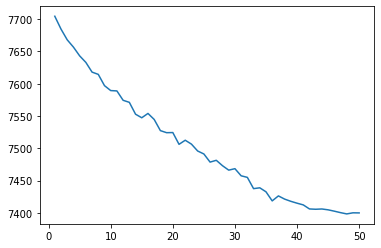

In [22]:
# cross validation

from sklearn.model_selection import train_test_split
X_train_08, X_test_02, Y_train_08, Y_test_02 = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

RMSE = []
for i in range(1, 51):
    print(i, end="\r")
    model = rfr(max_depth=5, n_estimators=200, max_features=i, random_state=3, bootstrap=True)
    model.fit(X_train_08, Y_train_08)
    RMSE.append(mean_squared_error(Y_test_02, model.predict(X_test_02), squared=False))
plt.plot(np.arange(1, 51), RMSE)
plt.show()

In [62]:
RMSE = np.array(RMSE)
max_feature = RMSE.argmin()
max_feature

47

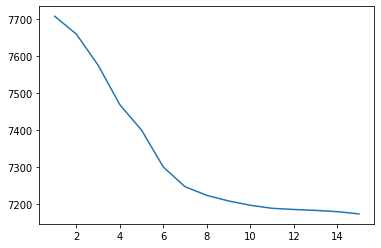

In [26]:
RMSE = []
E = 16
for i in range(1, E):
    print(i, end="\r")
    model = rfr(max_depth=i, n_estimators=200, max_features=max_feature, random_state=3, bootstrap=True)
    model.fit(X_train_08, Y_train_08)
    RMSE.append(mean_squared_error(Y_test_02, model.predict(X_test_02), squared=False))
plt.plot(np.arange(1, E), RMSE)

In [63]:
RMSE = np.array(RMSE)
max_depth = RMSE.argmin()
max_depth

14

In [45]:
RMSE = []
E = 301
for i in range(20, E, 20):
    print(i, end="\r")
    model = rfr(max_depth=max_depth, n_estimators=i, max_features=max_feature, random_state=3, bootstrap=True)
    model.fit(X_train_08, Y_train_08)
    RMSE.append(mean_squared_error(Y_test_02, model.predict(X_test_02), squared=False))


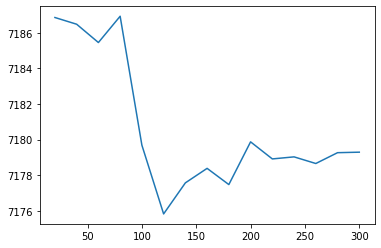

In [47]:
plt.plot(np.arange(20, E, 20), RMSE)


In [49]:
RMSE = np.array(RMSE)
n_estimators = np.arange(20, E, 20)[RMSE.argmin()]
n_estimators

120

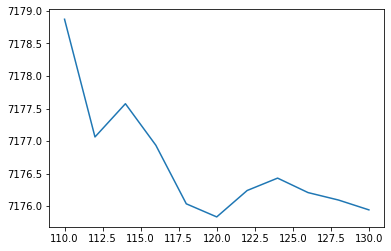

In [57]:
RMSE = []
E = 131
for i in range(110, E, 2):
    print(i, end="\r")
    model = rfr(max_depth=max_depth, n_estimators=i, max_features=max_feature, random_state=3, bootstrap=True)
    model.fit(X_train_08, Y_train_08)
    RMSE.append(mean_squared_error(Y_test_02, model.predict(X_test_02), squared=False))
plt.plot(range(110, E, 2), RMSE)


In [58]:
RMSE = np.array(RMSE)
np.arange(110, E, 2)[RMSE.argmin()]

120

In [69]:
model = rfr(max_depth=max_depth, n_estimators=n_estimators, max_features=max_feature, random_state=1, bootstrap=True)
model.fit(X_train, Y_train)
mean_squared_error(Y_train, model.predict(X_train), squared=False)

5998.737054547487

In [70]:
pd.DataFrame([np.array(X_train_df.columns)[np.arange(len(model.feature_importances_))], model.feature_importances_], index=["name", "importance"]).transpose().sort_values(by="importance", ascending=False)

,name,importance
5,6.0,0.121316
6,7.0,0.11737
4,5.0,0.065171
40,מחוז הדרום,0.052492
7,8.0,0.044132
26,עגבניות,0.043914
25,סלק,0.043091
17,גזרים,0.042708
2,3.0,0.042659
35,"תפו""א",0.042057


In [23]:
test_indices.reset_index(inplace=True)
if "index" in test_indices.columns:
    test_indices.drop(columns=["index"], inplace=True)
test_indices["month"] = list(map(lambda x: int(x.split("/")[1].split("-")[1]), test_indices.year_weeks))
test_indices["day"] = list(map(lambda x: int(x.split("/")[1].split("-")[2]), test_indices.year_weeks))
test_indices["season"] = list(map(lambda x: month_to_season(x), test_indices.month))

In [24]:
test_indices

,year_weeks,month,day,season
0,2020-01-13/2020-01-19,1,19,winter
1,2020-01-20/2020-01-26,1,26,winter
2,2020-01-27/2020-02-02,2,2,winter
3,2020-02-03/2020-02-09,2,9,winter
4,2020-02-10/2020-02-16,2,16,winter
...,...,...,...,...
126,2022-06-13/2022-06-19,6,19,spring
127,2022-06-20/2022-06-26,6,26,spring
128,2022-06-27/2022-07-03,7,3,summer
129,2022-07-04/2022-07-10,7,10,summer


In [25]:
foodDistrict = melted_train[["food", "district"]].drop_duplicates()
foodDistrict.reset_index(inplace=True)
foodDistrict.drop(columns="index", inplace=True)

In [86]:
X_cross = test_indices.merge(foodDistrict, how="cross")
X_cross = X_cross.merge(fitted_df, on="year_weeks", how="inner")
X_test_df = pd.concat([pd.get_dummies(X_cross["month"]),
                       # pd.get_dummies(X_cross["day"]),
                       # pd.get_dummies(X_cross["season"]),
                       # X_cross["Temperature"],
                       # X_cross["Relative Humidity"],
                       # X_cross["Wind Speed"],
                       # X_cross["Wind Direction"],
                       pd.get_dummies(X_cross["food"]),
                       pd.get_dummies(X_cross["district"])], axis=1)
X_test = X_test_df.to_numpy()
# print(X_test)

In [87]:
Y_pred = model.predict(X_test)
Y_pred = np.array(map(lambda x: x if x >= 0 else 0, Y_pred))
X_cross["pred"] = Y_pred
for e in zeros:
    food, location = e.split("_")
    X_cross.loc[(X_cross["food"] == food) & (X_cross["district"] == location), ["pred"]] = 0
Y_pred = X_cross["pred"].to_numpy()

# X_cross



In [66]:
Y_pred = bst.predict(xgb.DMatrix(X_test))

NameError: name 'bst' is not defined

In [88]:
X_cross["Weight"] = Y_pred

In [89]:
X_cross

,year_weeks,month,day,season,food,district,Temperature,Relative Humidity,Wind Speed,Wind Direction,pred,Weight
0,2020-01-13/2020-01-19,1,19,winter,other,יהודה ושומרון,5.953981,68.345238,9.402214,173.161423,35.128074,35.128074
1,2020-01-13/2020-01-19,1,19,winter,other,מחוז הדרום,5.953981,68.345238,9.402214,173.161423,3287.244681,3287.244681
2,2020-01-13/2020-01-19,1,19,winter,other,מחוז המרכז,5.953981,68.345238,9.402214,173.161423,2350.678723,2350.678723
3,2020-01-13/2020-01-19,1,19,winter,other,מחוז הצפון,5.953981,68.345238,9.402214,173.161423,3592.255319,3592.255319
4,2020-01-13/2020-01-19,1,19,winter,other,מחוז חיפה,5.953981,68.345238,9.402214,173.161423,369.617761,369.617761
...,...,...,...,...,...,...,...,...,...,...,...,...
24623,2022-07-11/2022-07-17,7,17,summer,תפוחים,מחוז הדרום,23.255172,45.988095,7.823682,153.208377,702.671905,702.671905
24624,2022-07-11/2022-07-17,7,17,summer,תפוחים,מחוז המרכז,23.255172,45.988095,7.823682,153.208377,634.632296,634.632296
24625,2022-07-11/2022-07-17,7,17,summer,תפוחים,מחוז הצפון,23.255172,45.988095,7.823682,153.208377,289.346311,289.346311
24626,2022-07-11/2022-07-17,7,17,summer,תפוחים,מחוז חיפה,23.255172,45.988095,7.823682,153.208377,220.597037,220.597037


In [90]:
def revert(df):
    df = pd.concat([df["year_weeks"], df[["food", "district"]].apply(lambda x: f"{x[0]}_{x[1]}", axis=1).rename("placeXfood"), df["Weight"]], axis=1)
    print("concat")
    df = df.set_index(["year_weeks", "placeXfood"])["Weight"].unstack()
    print("stacked")
    df.columns.name = None
    return df
finaldf = revert(X_cross[["year_weeks", "food", "district", "Weight"]])

concat
stacked


In [91]:
finaldf.to_csv("Answers.csv")